In [1]:
import random 
import time 
import numpy as np 
import cv2
import os 

from vizdoom import * 
from gym import Env 
from gym.spaces import Discrete, Box
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from matplotlib import pyplot as plt 
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
game = DoomGame()
game.load_config('./github/ViZDoom/scenarios/deadly_corridor-s1.cfg')
game.init()

In [3]:
actions = np.identity(7, dtype=np.uint8)
actions

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [4]:
state = game.get_state()

In [5]:
state.game_variables

array([100.,   0.,   0.,  -1.])

In [13]:
game.close()

In [7]:
episodes = 5 
game.init() 

for episode in range(episodes):
    game.new_episode() 
    while not game.is_episode_finished():
        state = game.get_state() 
        img = state.screen_buffer 
        info = state.game_variables 
        reward = game.make_action(random.choice(actions), 4)
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(0.5)

game.close()

Result: -83.84722900390625
Result: 32.017822265625
Result: 245.29666137695312
Result: 325.4327850341797
Result: -19.839401245117188


In [11]:
class VizDoom(Env):
    def __init__(self, render=False, config='./github/ViZDoom/scenarios/deadly_corridor-s1.cfg'):
        super().__init__() 
        self.game = DoomGame() 
        self.game.load_config(config)
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
            
        self.game.init()
        
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)
        
        self.damage_taken = 0 
        self.hitcount = 0
        self.ammo = 52
        
    def step(self, action):
        actions = np.identity(7)
        movement_reward = self.game.make_action(actions[action], 4)
        
        reward = 0
        if self.game.get_state():
            state = self.game.get_state().screen_buffer 
            state = self.grayscale(state)
            
            game_variables = self.game.get_state().game_variables 
            health, damage_taken, hitcount, ammo = game_variables
            
            damage_taken_delta = -damage_taken + self.damage_taken 
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount 
            self.hitcount = hitcount 
            ammo_delta = ammo - self.ammo 
            self.ammo = ammo 
            
            reward = movement_reward + damage_taken_delta * 10 + hitcount_delta * 200 + ammo_delta * 5
            info = ammo 
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
            
        info = {'info': info}
        done = self.game.is_episode_finished() 
        
        return state, reward, done, info
    
    def render():
        pass 
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer 
        return self.grayscale(state)
    
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state 
    
    def close(self):
        self.game.close()

In [33]:
env = VizDoom(render=True)

In [31]:
res = env.step(5)
res[1]

0.0

In [32]:
state = env.reset()

In [34]:
env_checker.check_env(env)

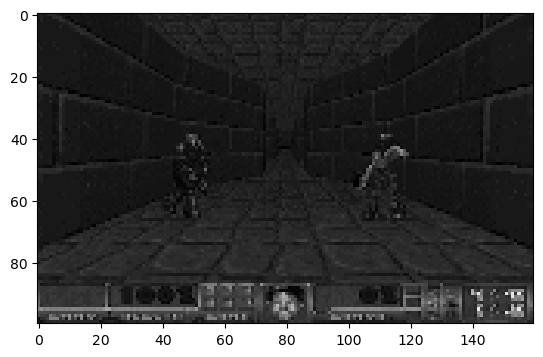

In [35]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
env.close()

In [54]:
class TrainingAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainingAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq 
        self.save_path = save_path 
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'deadly_corridor_best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [55]:
CHECKPOINT_DIR = './train/checkpoints'
LOG_DIR = './train/logs'

In [56]:
callback = TrainingAndLoggingCallback(check_freq=20000, save_path=CHECKPOINT_DIR)

In [57]:
env = VizDoom()

In [58]:
model = PPO('CnnPolicy', env, verbose=1, learning_rate=0.00001, 
            n_steps=2048, clip_range=.1, gamma=.95, gae_lambda=.9)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [59]:
model.learn(total_timesteps=100000, callback=callback)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 121      |
|    ep_rew_mean     | 112      |
| time/              |          |
|    fps             | 38       |
|    iterations      | 1        |
|    time_elapsed    | 53       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 151          |
|    ep_rew_mean          | 135          |
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 149          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036628444 |
|    clip_fraction        | 0.149        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained_variance   | -5.79e-05    |
|    learning_r

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 83           |
|    ep_rew_mean          | 483          |
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 11           |
|    time_elapsed         | 1015         |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0027042944 |
|    clip_fraction        | 0.275        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0.0916       |
|    learning_rate        | 1e-05        |
|    loss                 | 7.12e+03     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00681     |
|    value_loss           | 1.52e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 49.6         |
|    ep_rew_mean          | 691          |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 21           |
|    time_elapsed         | 1991         |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0044979793 |
|    clip_fraction        | 0.229        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.179        |
|    learning_rate        | 1e-05        |
|    loss                 | 1.65e+04     |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00474     |
|    value_loss           | 2.59e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 42.2         |
|    ep_rew_mean          | 840          |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 31           |
|    time_elapsed         | 2995         |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0019994194 |
|    clip_fraction        | 0.105        |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.853       |
|    explained_variance   | 0.258        |
|    learning_rate        | 1e-05        |
|    loss                 | 2.52e+04     |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00241     |
|    value_loss           | 3.22e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 42.3         |
|    ep_rew_mean          | 1.14e+03     |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 41           |
|    time_elapsed         | 3969         |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0015826012 |
|    clip_fraction        | 0.0469       |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.286       |
|    explained_variance   | 0.298        |
|    learning_rate        | 1e-05        |
|    loss                 | 1.41e+04     |
|    n_updates            | 400          |
|    policy_gradient_loss | 0.00119      |
|    value_loss           | 3.17e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

In [62]:
model.load('./train/checkpoints/deadly_corridor_best_model_100000.zip')
env = VizDoom(config='./github/ViZDoom/scenarios/deadly_corridor-s2.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.8     |
|    ep_rew_mean     | 870      |
| time/              |          |
|    fps             | 36       |
|    iterations      | 1        |
|    time_elapsed    | 56       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31.3         |
|    ep_rew_mean          | 858          |
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 162          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0026543448 |
|    clip_fraction        | 0.0363       |
|    clip_range           

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31.1         |
|    ep_rew_mean          | 895          |
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 11           |
|    time_elapsed         | 1089         |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0017620965 |
|    clip_fraction        | 0.0366       |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.107       |
|    explained_variance   | 0.421        |
|    learning_rate        | 1e-05        |
|    loss                 | 2.18e+04     |
|    n_updates            | 590          |
|    policy_gradient_loss | 0.00621      |
|    value_loss           | 3.65e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.2        |
|    ep_rew_mean          | 878         |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 21          |
|    time_elapsed         | 2127        |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.004571985 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.1         |
|    entropy_loss         | -0.108      |
|    explained_variance   | 0.505       |
|    learning_rate        | 1e-05       |
|    loss                 | 1.51e+04    |
|    n_updates            | 690         |
|    policy_gradient_loss | 0.00499     |
|    value_loss           | 3.01e+04    |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31.3

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30.9         |
|    ep_rew_mean          | 900          |
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 31           |
|    time_elapsed         | 3176         |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0021917492 |
|    clip_fraction        | 0.0324       |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.0701      |
|    explained_variance   | 0.565        |
|    learning_rate        | 1e-05        |
|    loss                 | 1.83e+04     |
|    n_updates            | 790          |
|    policy_gradient_loss | 0.00606      |
|    value_loss           | 2.94e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30           |
|    ep_rew_mean          | 822          |
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 41           |
|    time_elapsed         | 4209         |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0029403833 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.0408      |
|    explained_variance   | 0.575        |
|    learning_rate        | 1e-05        |
|    loss                 | 1.31e+04     |
|    n_updates            | 890          |
|    policy_gradient_loss | 0.00395      |
|    value_loss           | 2.84e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

In [63]:
model.load('./train/checkpoints/deadly_corridor_best_model_200000.zip')
env = VizDoom(config='./github/ViZDoom/scenarios/deadly_corridor-s3.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.3     |
|    ep_rew_mean     | 767      |
| time/              |          |
|    fps             | 39       |
|    iterations      | 1        |
|    time_elapsed    | 52       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29.2         |
|    ep_rew_mean          | 765          |
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 150          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0029093781 |
|    clip_fraction        | 0.013        |
|    clip_range           

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.4        |
|    ep_rew_mean          | 809         |
| time/                   |             |
|    fps                  | 21          |
|    iterations           | 11          |
|    time_elapsed         | 1037        |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.002360819 |
|    clip_fraction        | 0.0155      |
|    clip_range           | 0.1         |
|    entropy_loss         | -0.0301     |
|    explained_variance   | 0.63        |
|    learning_rate        | 1e-05       |
|    loss                 | 1.61e+04    |
|    n_updates            | 1080        |
|    policy_gradient_loss | 0.00216     |
|    value_loss           | 2.71e+04    |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 30

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30.3         |
|    ep_rew_mean          | 834          |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 21           |
|    time_elapsed         | 2026         |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0016025008 |
|    clip_fraction        | 0.00688      |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.0183      |
|    explained_variance   | 0.62         |
|    learning_rate        | 1e-05        |
|    loss                 | 1.36e+04     |
|    n_updates            | 1180         |
|    policy_gradient_loss | 0.00116      |
|    value_loss           | 3.05e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.9         |
|    ep_rew_mean          | 778          |
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 31           |
|    time_elapsed         | 3093         |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0006203741 |
|    clip_fraction        | 0.00635      |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.0258      |
|    explained_variance   | 0.616        |
|    learning_rate        | 1e-05        |
|    loss                 | 1.58e+04     |
|    n_updates            | 1280         |
|    policy_gradient_loss | 0.00224      |
|    value_loss           | 2.74e+04     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 32           |
|    ep_rew_mean          | 928          |
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 41           |
|    time_elapsed         | 4093         |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0034967223 |
|    clip_fraction        | 0.0256       |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.0196      |
|    explained_variance   | 0.551        |
|    learning_rate        | 1e-05        |
|    loss                 | 2.09e+04     |
|    n_updates            | 1380         |
|    policy_gradient_loss | 4.87e-06     |
|    value_loss           | 2.54e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

In [64]:
model.load('./train/checkpoints/deadly_corridor_best_model_300000.zip')
env = VizDoom(config='./github/ViZDoom/scenarios/deadly_corridor-s4.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.8     |
|    ep_rew_mean     | 930      |
| time/              |          |
|    fps             | 40       |
|    iterations      | 1        |
|    time_elapsed    | 51       |
|    total_timesteps | 2048     |
---------------------------------


KeyboardInterrupt: 

In [ ]:
model.load('./train/checkpoints/deadly_corridor_best_model_400000.zip')
env = VizDoom(config='./github/ViZDoom/scenarios/deadly_corridor-s5.cfg')
model.set_env(env)
model.learn(total_timesteps=100000, callback=callback)

In [65]:
model = PPO.load('./train/checkpoints/deadly_corridor_best_model_300000.zip')

In [67]:
env = VizDoom(render=True, config='./github/VizDoom/scenarios/deadly_corridor-s1.cfg')

In [68]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\86183\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [69]:
mean_reward

1287.0029678344727

In [70]:
for episode in range(10):
    obs = env.reset() 
    done = False 
    total_reward = 0 
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.02)
        total_reward += reward 
    print('Total reward for episode {} is {}'.format(episode + 1, total_reward))
env.close()

Total reward for episode 1 is 1497.4813385009766
Total reward for episode 2 is 1257.4813385009766
Total reward for episode 3 is 2217.917465209961
Total reward for episode 4 is 2124.9720153808594
Total reward for episode 5 is 2442.1846771240234
Total reward for episode 6 is 1317.4813385009766
Total reward for episode 7 is 1218.882308959961
Total reward for episode 8 is 845.1804656982422
Total reward for episode 9 is 1717.4813385009766
Total reward for episode 10 is 1257.4813385009766
